#### Random Forest and GBDT Algorithm on Donors_Choose dataset

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import gc
gc.enable()
gc.DEBUG_SAVEALL
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import math 
# from plotly import plotly
# import plotly.offline as offline
# import plotly.graph_objs as go
# offline.init_notebook_mode()
from collections import Counter
gc.set_threshold(2, 1, 1)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#### 2.1 Loading Input Data

In [0]:
# %load_ext memory_profiler
s=0
# We are taking samples of 0's and 1's and appending them to overcome memory error
project_data = pd.read_csv('/content/drive/My Drive/train_data.csv')
# project_data=project_data.dropna(how='any')
project_data_1 = project_data[project_data['project_is_approved'] == s+1]
project_data_0 = project_data[project_data['project_is_approved'] == s]
project_data=project_data.fillna("")
project_data_1=project_data_1.head(10000)
project_data_0=project_data_0.tail(10000)
project_data_1=project_data_1.append(project_data_0)
project_data=project_data_1
resource_data = pd.read_csv('/content/drive/My Drive/resources.csv')

#Sorting them by columns to spread the zeros and one's unevenly in the 'project_is_approved' column
project_data.sort_values(by=['project_essay_1'])
project_data.sort_values(by=['project_essay_2'], ascending=False)
project_data.sort_values(by=['project_essay_3'])
project_data.sort_values(by=['project_essay_4'], ascending=False)
project_data_1=None
project_data_0=None

In [0]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (20000, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [0]:
print("Number of data points in resource data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(1)
# project_data.head(2)

Number of data points in resource data (1541272, 4)
['id' 'description' 'quantity' 'price']


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.0


In [0]:
y = project_data['project_is_approved'].values
X = project_data.drop(['project_is_approved'], axis=1)
X.head(1)
project_data=None
gc.collect()
gc.enable()
gc.DEBUG_SAVEALL

32

#### 2.2 Getting the Data Model Ready:Preprocessing and Vectorizing categorical features

#### 2.2.1 Preprocessing:project_grade_category

In [0]:
sub_catogories = list(X['project_grade_category'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())
X['project_grade_category'] = sub_cat_list

In [0]:
sub_catogories=None
sub_cat_list=None
temp=None
i=None
j=None
catogories=None
cat_list=None
temp=None
my_counter=None
word=None
cat_dict=None
gc.collect()
gc.enable()
gc.DEBUG_SAVEALL

32

#### 2.2.2 Preprocessing:project_subject_categories

In [0]:
catogories = list(X['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())

X['clean_categories'] = cat_list
X.drop(['project_subject_categories'], axis=1, inplace=True)
X.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,clean_categories
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,10/25/2016 9:22,Grades6-8,"Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,History_Civics Health_Sports
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs.,KY,10/6/2016 21:16,GradesPreK-2,"Literacy, Mathematics",Techie Kindergarteners,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,My students need to engage in Reading and Math...,4,Literacy_Language Math_Science


#### 2.2.3 Preprocessing:project_subject_subcategories

In [0]:
sub_catogories = list(X['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

In [0]:
X['clean_subcategories'] = sub_cat_list
X.drop(['project_subject_subcategories'], axis=1, inplace=True)
X.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,10/25/2016 9:22,Grades6-8,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,History_Civics Health_Sports,Civics_Government TeamSports
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs.,KY,10/6/2016 21:16,GradesPreK-2,Techie Kindergarteners,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,My students need to engage in Reading and Math...,4,Literacy_Language Math_Science,Literacy Mathematics


#### 2.2.4 New Column:digits in summary

In [0]:
# Creating a new column 'digits_in_summary' which contains flags of 1 for /
# 'project_resource_summary' containing numeric specification in their requiremnt.
project_resource_summary = []
new=[]

project_resource_summary = list(X['project_resource_summary'].values)

for i in project_resource_summary:
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(' '):
        if j.isdigit():
            new.append(1)
            break
        else:
            continue
    else:
        new.append(0)
              

X['digits_in_summary']=new

In [0]:
#To make best use of the memory we are setting the variable names to 'None' and performing garbage collection.
project_resource_summary=None
new=None
new1=None
i=None
j=None
a=None

gc.collect()
gc.enable()
gc.DEBUG_SAVEALL

32

#### 2.2.5 Preprocessing:Text features (Project Essay's)

In [0]:
# merge two column text dataframe: 
X["essay"] = X["project_essay_1"].map(str) +\
                        X["project_essay_2"].map(str) + \
                        X["project_essay_3"].map(str) + \
                        X["project_essay_4"].map(str)


In [0]:
X = X.drop(['project_essay_1', 'project_essay_2','project_essay_3', 'project_essay_4'], axis=1)
X.shape

(20000, 14)

#### 2.2.6 Adding column Cost per project in dataset

In [0]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)
type(price_data)

pandas.core.frame.DataFrame

In [0]:
# join two dataframes in python: 
X = pd.merge(X, price_data, on='id', how='left')
X.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,digits_in_summary,essay,price,quantity
0,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,10/25/2016 9:22,Grades6-8,Wanted: Projector for Hungry Learners,My students need a projector to help with view...,7,History_Civics Health_Sports,Civics_Government TeamSports,0,Our students arrive to our school eager to lea...,299.0,1
1,45,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs.,KY,10/6/2016 21:16,GradesPreK-2,Techie Kindergarteners,My students need to engage in Reading and Math...,4,Literacy_Language Math_Science,Literacy Mathematics,0,I work at a unique school filled with both ESL...,232.9,4


In [0]:
#To make best use of the memory we are setting the variable names to 'None' and performing garbage collection.
resource_data=None
price_data=None
gc.collect()
gc.enable()
gc.DEBUG_SAVEALL

32

#### 2.2.7 Text Preprocessing:Essay Text

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent = decontracted(X['essay'].values[99])
print(sent)
print("="*50)

What does \"The message in the music\" mean to you? To my kids, it means so much more! Music is not just for entertainment!  My kids are learning how music can be used as a human rights tool! They are learning to express their feelings of the world around them in positive ways.\r\n\r\nMy kids are every stereotype you can think of: poor, underprivileged, rough, angry.  Turn that same prism around there is also joy, happiness, intelligence and creativity. They are learning to navigate the world around them and we are working on showing them how to use this energy in a positive way.Our piano lab is aging.  We have 3 classes of 35 kids that are bursting at the gills, which is a great problem to have!  BUT keyboards are beginning to have the keys break off making them unuseable. We also do not have enough keyboards for every student in class, even if you counted the slightly broken ones!\r\n\r\nWe are in desperate need of more keyboards for our labs to meet the needs of our students.  A key

In [0]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

What does  The message in the music  mean to you? To my kids, it means so much more! Music is not just for entertainment!  My kids are learning how music can be used as a human rights tool! They are learning to express their feelings of the world around them in positive ways.    My kids are every stereotype you can think of: poor, underprivileged, rough, angry.  Turn that same prism around there is also joy, happiness, intelligence and creativity. They are learning to navigate the world around them and we are working on showing them how to use this energy in a positive way.Our piano lab is aging.  We have 3 classes of 35 kids that are bursting at the gills, which is a great problem to have!  BUT keyboards are beginning to have the keys break off making them unuseable. We also do not have enough keyboards for every student in class, even if you counted the slightly broken ones!    We are in desperate need of more keyboards for our labs to meet the needs of our students.  A keyboard for 

In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

What does The message in the music mean to you To my kids it means so much more Music is not just for entertainment My kids are learning how music can be used as a human rights tool They are learning to express their feelings of the world around them in positive ways My kids are every stereotype you can think of poor underprivileged rough angry Turn that same prism around there is also joy happiness intelligence and creativity They are learning to navigate the world around them and we are working on showing them how to use this energy in a positive way Our piano lab is aging We have 3 classes of 35 kids that are bursting at the gills which is a great problem to have BUT keyboards are beginning to have the keys break off making them unuseable We also do not have enough keyboards for every student in class even if you counted the slightly broken ones We are in desperate need of more keyboards for our labs to meet the needs of our students A keyboard for each student in class will facilit

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [0]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(X['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|██████████| 20000/20000 [00:11<00:00, 1671.72it/s]


In [0]:
# after preprocesing

# X['essay'] = None
X['essay'] = preprocessed_essays

X.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,digits_in_summary,essay,price,quantity
0,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,10/25/2016 9:22,Grades6-8,Wanted: Projector for Hungry Learners,My students need a projector to help with view...,7,History_Civics Health_Sports,Civics_Government TeamSports,0,our students arrive school eager learn they po...,299.0,1
1,45,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs.,KY,10/6/2016 21:16,GradesPreK-2,Techie Kindergarteners,My students need to engage in Reading and Math...,4,Literacy_Language Math_Science,Literacy Mathematics,0,i work unique school filled esl english second...,232.9,4


In [0]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_project_title = []
# tqdm is for printing the status bar
for sentance in tqdm(X['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_project_title.append(sent.lower().strip())

100%|██████████| 20000/20000 [00:00<00:00, 33131.70it/s]


In [0]:
preprocessed_project_title[4999]
# after preprocesing

# X['project_title'] = None
X['project_title'] = preprocessed_project_title

X.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,digits_in_summary,essay,price,quantity
0,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,10/25/2016 9:22,Grades6-8,wanted projector hungry learners,My students need a projector to help with view...,7,History_Civics Health_Sports,Civics_Government TeamSports,0,our students arrive school eager learn they po...,299.0,1
1,45,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs.,KY,10/6/2016 21:16,GradesPreK-2,techie kindergarteners,My students need to engage in Reading and Math...,4,Literacy_Language Math_Science,Literacy Mathematics,0,i work unique school filled esl english second...,232.9,4


#### 2.2.8 Splitting the data into Train and Test

In [0]:
# train test split(67:33)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
# X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)
X=None
gc.collect()

11

#### 2.2.9 Response Coding Categorical data:

In [0]:
def res_code(X_tr,y_tr,cc,cc_0,cc_1):
    #We are concatinating train data and its classes to create a base table while creating the response table
    df=pd.DataFrame(X_tr,columns=[cc]) #Train data
    df1=pd.DataFrame(y_tr,columns=['y']) #Train class
    df.reset_index(drop=True, inplace=True)
    df1.reset_index(drop=True, inplace=True)
    df_row = df.assign(y=df1) #concatenating of the train and  train class  
#     df_row.to_csv('file2.csv')
    #========================*************************=======================================******************================
    #To create response table for the given category
    group_data = df_row.groupby([cc]).count() #We groupby with respect to the category and obtain its count
    df_row['id'] = df_row[cc].str.cat(df_row['y'].values.astype(str)) #We concat the category and the class to obtain the count of the classes wrt the each category
    group_data1 = df_row.groupby(['id'])['y'].count() #We are obtaining the count of the classes wrt each category
    group_data1=group_data1.to_frame() #Converting to dataframe
    #========================*************************=======================================******************================
    #We have two tables group_data which holds the category count and group_data1 which holds the count of the classes wrt each category
    df_row = pd.merge(df_row,group_data, on=cc, how='left') #On the base data we merge to add a new column which holds the category count
    df_row = pd.merge(df_row,group_data1,on='id', how='left') #On the base data we merge to add a new column which holds the count of the classes
    #======================**************************=======================================********************===============
    #Final Response table creation wrt class 0 and class 0
    df_row_1 = df_row[df_row['y_x']==1] #Breaking the table wrt class 1
    df_row_0 = df_row[df_row['y_x']==0] #Breaking the table wrt class 0
    df_row_0[cc_0]=df_row_0['y']/df_row_0['y_y'] #We are taking the percentage of each class wrt each category 0 and creating a column
    df_row_1[cc_1]=df_row_1['y']/df_row_1['y_y'] #We are taking the percentage of each class wrt each category 1 and creating a column
    df_row_0=df_row_0.drop(['y_x', 'id','y_y','y'], axis=1) #Dropping unwanted columns
    df_row_1=df_row_1.drop(['y_x', 'id','y_y','y'], axis=1) #Dropping unwanted columns
    df_row=df_row.drop(['y_x', 'id','y_y','y'], axis=1) #Dropping unwanted columns
    #=====================**************************=======================================*********************================
    df_row_0=df_row_0.drop_duplicates() #Dropping the duplicates
    df_row_1=df_row_1.drop_duplicates() #Dropping the duplicates
    X_tr = pd.merge(X_tr,df_row_1, on=cc, how='left') #Merging the class 1 percentage column
    X_tr = pd.merge(X_tr,df_row_0, on=cc, how='left') #Merging the class 0 percentage column
    X_tr[cc_0]=round((X_tr[cc_0])*100,2) #We are multiplying the percentage and rounding off to two decimal points
    X_tr[cc_1]=round((X_tr[cc_1])*100,2) #We are multiplying the percentage and rounding off to two decimal points
    X_tr=X_tr.drop([cc], axis=1) #We are dropping the category column
    X_tra=X_tr
    return X_tra


In [0]:
#  Response Coding Categorical data: clean_subcategories(Project subject categories)
CC='clean_categories'
CC_0='St_0_cl_cat'
CC_1='St_1_cl_cat'

X_train=res_code(X_train,y_train,CC,CC_0,CC_1)
X_test=res_code(X_test,y_test,CC,CC_0,CC_1)

#  Response Coding Categorical data: clean_subcategories(Project subject subcategories)
CC = 'clean_subcategories'
CC_0='St_0_sub_cat'
CC_1='St_1_sub_cat'
X_train=res_code(X_train,y_train,CC,CC_0,CC_1)
X_test=res_code(X_test,y_test,CC,CC_0,CC_1)

#  Response Coding Categorical data:(school_state)
CC = 'school_state'
CC_0='St_0_sc_st'
CC_1='St_1_sc_st'
X_train=res_code(X_train,y_train,CC,CC_0,CC_1)
X_test=res_code(X_test,y_test,CC,CC_0,CC_1)

#  Response Coding Categorical data: (project_grade_category)
CC = 'project_grade_category'
CC_0='St_0_pgc'
CC_1='St_1_pgc'
X_train=res_code(X_train,y_train,CC,CC_0,CC_1)
X_test=res_code(X_test,y_test,CC,CC_0,CC_1)

#  Response Coding Categorical data: (project_grade_category)
CC = 'teacher_prefix'
CC_0='St_0_tp'
CC_1='St_1_tp'
X_train=res_code(X_train,y_train,CC,CC_0,CC_1)
X_test=res_code(X_test,y_test,CC,CC_0,CC_1)
# X_train.to_csv('train_cc.csv')
# X_test.to_csv('test_cc.csv')

In [0]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
X_train.head(3)

,Unnamed: 0,id,teacher_id,project_submitted_datetime,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,digits_in_summary,essay,price,quantity,St_1_cl_cat,St_0_cl_cat,St_1_sub_cat,St_0_sub_cat,St_1_sc_st,St_0_sc_st,St_1_pgc,St_0_pgc,St_1_tp,St_0_tp
0,31112,p007096,64972ed7a628ea702c4d94718d6c94e5,9/16/2016 22:04,projects creations art oh my,My students need art supplies to create projec...,3,0,i teach urban school 100 students receive free...,212.28,45,53.85,46.15,54.02,45.98,58.27,41.73,50.05,49.95,51.07,48.93
1,96103,p043613,5832aaf8f511ad06b4a65eaaa072e7c7,12/20/2016 20:09,building forever readers,My students need a variety of books to help me...,1,0,for many students school place find stability ...,109.11,4,55.04,44.96,59.92,40.08,51.60,48.40,51.32,48.68,51.07,48.93
2,135075,p145470,8448b4ab04a2f5e3c09bc95bb8717a5d,3/8/2017 14:09,got chromebooks,My students need 5 chromebooks with headphones...,12,1,my students amazing curious learners excited s...,190.82,15,55.04,44.96,53.62,46.38,50.48,49.52,51.32,48.68,49.59,50.41


#### 2.3 Make Data Model Ready: Vectorizing Numerical features

#### 2.3.1 Vectorizing Numerical features--Price

In [0]:
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
normalizer = StandardScaler() #Normalizer()
# normalizer_test = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['price'].values.reshape(-1,1))
# normalizer_test.fit(X_test['price'].values.reshape(1,-1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
# X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))


# X_train_price_norm=np.reshape(X_train_price_norm,(1,-1))
# X_test_price_norm=np.reshape(X_test_price_norm,(1,-1))

print("After vectorizations")

# np.reshape(X_train_price_norm,
print(X_train_price_norm.shape, y_train.shape)
# print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(13400, 1) (13400,)
(6600, 1) (6600,)


#### 2.3.2 Vectorizing Numerical features--teacher_number_of_previously_posted_projects

In [0]:
from sklearn.preprocessing import Normalizer
normalizer_train = StandardScaler() #Normalizer()
normalizer_test = StandardScaler() #Normalizer()
# normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_teacher_number_of_previously_posted_projects_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
# X_cv_teacher_number_of_previously_posted_projects_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_teacher_number_of_previously_posted_projects_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))



# X_train_teacher_number_of_previously_posted_projects_norm=np.reshape(X_train_teacher_number_of_previously_posted_projects_norm,(1,-1))
# X_test_teacher_number_of_previously_posted_projects_norm=np.reshape(X_test_teacher_number_of_previously_posted_projects_norm,(1,-1))


print("After vectorizations")
print(X_train_teacher_number_of_previously_posted_projects_norm.shape, y_train.shape)
# print(X_cv_teacher_number_of_previously_posted_projects_norm.shape, y_cv.shape)
print(X_test_teacher_number_of_previously_posted_projects_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(13400, 1) (13400,)
(6600, 1) (6600,)


#### 2.3.3 Vectorizing Numerical features--digits_in_summary

In [0]:
X_train['digits_in_summary'].fillna(X_train['digits_in_summary'].mean(), inplace=True)
# X_cv['digits_in_summary'].fillna(X_cv['digits_in_summary'].mean(), inplace=True)
X_test['digits_in_summary'].fillna(X_test['digits_in_summary'].mean(), inplace=True)

In [0]:
from sklearn.preprocessing import Normalizer
normalizer_train = StandardScaler() #Normalizer()
normalizer_test = StandardScaler() #Normalizer()
# normalizer.fit(X_train['digits_in_summary'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['digits_in_summary'].values.reshape(-1,1))

X_train_digits_in_summary_norm = normalizer.transform(X_train['digits_in_summary'].values.reshape(-1,1))
# X_cv_digits_in_summary_norm = normalizer.transform(X_cv['digits_in_summary'].values.reshape(1,-1))
X_test_digits_in_summary_norm = normalizer.transform(X_test['digits_in_summary'].values.reshape(-1,1))


# X_train_digits_in_summary_norm=np.reshape(X_train_digits_in_summary_norm,(1,-1))
# X_test_digits_in_summary_norm=np.reshape(X_test_digits_in_summary_norm,(1,-1))

print("After vectorizations")
print(X_train_digits_in_summary_norm.shape, y_train.shape)
# print(X_cv_digits_in_summary_norm.shape, y_cv.shape)
print(X_test_digits_in_summary_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(13400, 1) (13400,)
(6600, 1) (6600,)


#### 2.4 Make Data Model Ready: Vectorizing Essay and Project_title feature into BOW & TFIDF

#### Vectorizing Text data

#### 2.4.1 Bag of words:Essays

In [0]:
print(X_train.shape, y_train.shape)
# print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)

# We are considering only the words which appeared in at least 10 documents(rows or projects).max_features=1000 is set to overcome the memory issue by reducing the no of features

vectorizer = CountVectorizer(min_df=10,ngram_range=(2,2), max_features=5000)
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted Countvectorizer to convert the text to vector
X_train_essay_bow = vectorizer.transform(X_train['essay'].values)
# X_cv_essay_bow = vectorizer.transform(X_cv['essay'].values)
X_test_essay_bow = vectorizer.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_bow.shape, y_train.shape)
# print(X_cv_essay_bow.shape, y_cv.shape)
print(X_test_essay_bow.shape, y_test.shape)
print("="*100)


(13400, 21) (13400,)
(6600, 21) (6600,)
After vectorizations
(13400, 5000) (13400,)
(6600, 5000) (6600,)


#### 2.4.2 Bag of words:Project Title

In [0]:

print(X_train.shape, y_train.shape)
# print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer = CountVectorizer(min_df=10,ngram_range=(2,2), max_features=5000)
vectorizer.fit(X_train['project_title'].values) # fit has to happen only on train data

# we use the fitted Countvectorizer to convert the text to vector
X_train_project_title_bow = vectorizer.transform(X_train['project_title'].values)
# X_cv_project_title_bow = vectorizer.transform(X_cv['project_title'].values)
X_test_project_title_bow = vectorizer.transform(X_test['project_title'].values)

print("After vectorizations")
print(X_train_project_title_bow.shape, y_train.shape)
# print(X_cv_project_title_bow.shape, y_cv.shape)
print(X_test_project_title_bow.shape, y_test.shape)

print("="*100)

(13400, 21) (13400,)
(6600, 21) (6600,)
After vectorizations
(13400, 313) (13400,)
(6600, 313) (6600,)


#### 2.4.3 Converting Columns into array before merging into hstack

In [0]:
X_train_St_0_cl_cat = X_train['St_0_cl_cat'].values.reshape(-1,1)
X_train_St_1_cl_cat = X_train['St_1_cl_cat'].values.reshape(-1,1)

X_train_St_0_sub_cat = X_train['St_0_sub_cat'].values.reshape(-1,1)
X_train_St_1_sub_cat = X_train['St_1_sub_cat'].values.reshape(-1,1)

X_train_St_0_sc_st = X_train['St_0_sc_st'].values.reshape(-1,1)
X_train_St_1_sc_st = X_train['St_1_sc_st'].values.reshape(-1,1)

X_train_St_0_pgc = X_train['St_0_pgc'].values.reshape(-1,1)
X_train_St_1_pgc = X_train['St_1_pgc'].values.reshape(-1,1)

X_train_St_0_tp = X_train['St_0_tp'].values.reshape(-1,1)
X_train_St_1_tp = X_train['St_1_tp'].values.reshape(-1,1)


# ==========================**************============================

X_test_St_0_cl_cat = X_test['St_0_cl_cat'].values.reshape(-1,1)
X_test_St_1_cl_cat = X_test['St_1_cl_cat'].values.reshape(-1,1)

X_test_St_0_sub_cat = X_test['St_0_sub_cat'].values.reshape(-1,1)
X_test_St_1_sub_cat = X_test['St_1_sub_cat'].values.reshape(-1,1)

X_test_St_0_sc_st = X_test['St_0_sc_st'].values.reshape(-1,1)
X_test_St_1_sc_st = X_test['St_1_sc_st'].values.reshape(-1,1)

X_test_St_0_pgc = X_test['St_0_pgc'].values.reshape(-1,1)
X_test_St_1_pgc = X_test['St_1_pgc'].values.reshape(-1,1)

X_test_St_0_tp = X_test['St_0_tp'].values.reshape(-1,1)
X_test_St_1_tp = X_test['St_1_tp'].values.reshape(-1,1)


In [0]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_BOW_TRAIN = hstack((X_train_digits_in_summary_norm,X_train_teacher_number_of_previously_posted_projects_norm,X_train_price_norm,X_train_project_title_bow,X_train_essay_bow,X_train_St_0_cl_cat,X_train_St_1_cl_cat,X_train_St_0_sub_cat,X_train_St_1_sub_cat,X_train_St_0_sc_st,X_train_St_1_sc_st,X_train_St_0_pgc,X_train_St_1_pgc,X_train_St_0_tp,X_train_St_1_tp
))
X_BOW_TRAIN=X_BOW_TRAIN.todense()
X_BOW_TRAIN=np.array(X_BOW_TRAIN)

# X_BOW_cv = hstack((X_cv_project_title_bow,X_cv_essay_bow ,X_cv_digits_in_summary_norm,X_cv_teacher_number_of_previously_posted_projects_norm,X_cv_price_norm,X_cv_teacher_prefix_ohe,X_cv_project_grade_category_ohe,X_cv_School_state_ohe,X_cv_clean_sub_cat_ohe,X_cv_clean_cat_ohe))
# X_BOW_cv=X_BOW_cv.todense()
# X_BOW_cv=np.array(X_BOW_cv)

X_BOW_test = hstack((X_test_digits_in_summary_norm,X_test_teacher_number_of_previously_posted_projects_norm,X_test_price_norm,X_test_project_title_bow,X_test_essay_bow,X_test_St_0_cl_cat,X_test_St_1_cl_cat,X_test_St_0_sub_cat,X_test_St_1_sub_cat,X_test_St_0_sc_st,X_test_St_1_sc_st,X_test_St_0_pgc,X_test_St_1_pgc,X_test_St_0_tp,X_test_St_1_tp
))
X_BOW_test=X_BOW_test.todense()
X_BOW_test=np.array(X_BOW_test)

# X_train_project_title_bow=None
# X_train_essay_bow =None

# X_test_project_title_bow=None
# X_test_essay_bow =None

In [0]:
print(X_train_digits_in_summary_norm.shape)
print(X_train_teacher_number_of_previously_posted_projects_norm.shape)
print(X_train_price_norm.shape)
print(X_train_project_title_bow.shape)
print(X_train_essay_bow.shape)
print(X_train_St_0_cl_cat.shape)
print(X_train_St_1_cl_cat.shape)
print(X_train_St_0_sub_cat.shape)
print(X_train_St_1_sub_cat.shape)
print(X_train_St_0_sc_st.shape)
print(X_train_St_1_sc_st.shape)
print(X_train_St_0_pgc.shape)
print(X_train_St_1_pgc.shape)
print(X_train_St_0_tp.shape)
print(X_train_St_1_tp.shape)

(13400, 1)
(13400, 1)
(13400, 1)
(13400, 313)
(13400, 5000)
(13400, 1)
(13400, 1)
(13400, 1)
(13400, 1)
(13400, 1)
(13400, 1)
(13400, 1)
(13400, 1)
(13400, 1)
(13400, 1)


#### 2.7 AVG_W2V

#### 2.7.1 Using Pretrained Models: Avg W2V-Essays

In [0]:
# train test split
from sklearn.model_selection import train_test_split

avg_w2v_vectors_essay_train_, avg_w2v_vectors_essay_test_, y_train, y_test = train_test_split(preprocessed_essays, y, test_size=0.33, stratify=y)

# avg_w2v_vectors_essay_train, avg_w2v_vectors_essay_cv, y_train, y_cv = train_test_split(avg_w2v_vectors_essay_train, y_train, test_size=0.33, stratify=y_train)

In [0]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
import pickle
with open('/content/drive/My Drive/glove_vectors', 'rb') as f:
    model_ = pickle.load(f)
    glove_words =  set(model_.keys())

In [0]:
# average Word2Vec
# compute average word2vec for each review.
from tqdm import tqdm
# sentence=[]
avg_w2v_vectors_essay_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(avg_w2v_vectors_essay_train_): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model_[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_essay_train.append(vector)

print(len(avg_w2v_vectors_essay_train))
print(len(avg_w2v_vectors_essay_train[0]))

100%|██████████| 13400/13400 [00:04<00:00, 3013.82it/s]

13400
300


In [0]:
# average Word2Vec
# compute average word2vec for each review.
from tqdm import tqdm
avg_w2v_vectors_essay_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(avg_w2v_vectors_essay_test_): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model_[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_essay_test.append(vector)

print(len(avg_w2v_vectors_essay_test))
print(len(avg_w2v_vectors_essay_test[0]))

100%|██████████| 6600/6600 [00:02<00:00, 2929.26it/s]

6600
300


In [0]:
# # We are considering only the words which appeared in at least 10 documents(rows or projects).
# vectorizer = CountVectorizer(min_df=10,max_features=1000)
# project_essay_avg_w2v = vectorizer.fit_transform(avg_w2v_vectors_essay)
# print("Shape of matrix after one hot encodig ",project_essay_avg_w2v.shape)

import scipy   
avg_w2v_vectors_essay_train=scipy.sparse.csr_matrix(avg_w2v_vectors_essay_train)
# type(avg_w2v_vectors_essay)

import scipy   
avg_w2v_vectors_essay_test=scipy.sparse.csr_matrix(avg_w2v_vectors_essay_test)
# type(avg_w2v_vectors_essay_test)

#### 2.7.2 Using Pretrained Models: AVG W2V on `project_title`

In [0]:
# train test split
from sklearn.model_selection import train_test_split

avg_w2v_vectors_Pro_title_train_, avg_w2v_vectors_Pro_title_test_, y_train, y_test = train_test_split(preprocessed_project_title, y, test_size=0.33, stratify=y)

# avg_w2v_vectors_Pro_title_train, avg_w2v_vectors_Pro_title_cv, y_train, y_cv = train_test_split(avg_w2v_vectors_Pro_title_train, y_train, test_size=0.33, stratify=y_train)

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(avg_w2v_vectors_Pro_title_train_)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [0]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_Pro_title_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(avg_w2v_vectors_Pro_title_train_): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model_[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_Pro_title_train.append(vector)

print(len(avg_w2v_vectors_Pro_title_train))
print(len(avg_w2v_vectors_Pro_title_train[0]))

100%|██████████| 13400/13400 [00:00<00:00, 57885.12it/s]

13400
300


In [0]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_Pro_title_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(avg_w2v_vectors_Pro_title_test_): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model_[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_Pro_title_test.append(vector)

print(len(avg_w2v_vectors_Pro_title_test))
print(len(avg_w2v_vectors_Pro_title_test[0]))

100%|██████████| 6600/6600 [00:00<00:00, 63768.33it/s]

6600
300


In [0]:
import scipy   
avg_w2v_vectors_Pro_title_train=scipy.sparse.csr_matrix(avg_w2v_vectors_Pro_title_train)
type(avg_w2v_vectors_Pro_title_train)

import scipy   
avg_w2v_vectors_Pro_title_test=scipy.sparse.csr_matrix(avg_w2v_vectors_Pro_title_test)
type(avg_w2v_vectors_Pro_title_test)

# import scipy   
# avg_w2v_vectors_Pro_title_cv=scipy.sparse.csr_matrix(avg_w2v_vectors_Pro_title_cv)
# type(avg_w2v_vectors_Pro_title_cv)

scipy.sparse.csr.csr_matrix

In [0]:
X_avg_w2v_train = hstack(( avg_w2v_vectors_Pro_title_train,avg_w2v_vectors_essay_train,X_train_digits_in_summary_norm,X_train_teacher_number_of_previously_posted_projects_norm,X_train_price_norm,X_train_St_0_cl_cat,X_train_St_1_cl_cat,X_train_St_0_sub_cat,X_train_St_1_sub_cat,X_train_St_0_sc_st,X_train_St_1_sc_st,X_train_St_0_pgc,X_train_St_1_pgc,X_train_St_0_tp,X_train_St_1_tp
))
X_avg_w2v_train=X_avg_w2v_train.todense()
X_avg_w2v_train=np.array(X_avg_w2v_train)

# X_avg_w2v_cv = hstack(( avg_w2v_vectors_Pro_title_cv,avg_w2v_vectors_essay_cv,X_cv_digits_in_summary_norm,X_cv_teacher_number_of_previously_posted_projects_norm,X_cv_price_norm,X_cv_teacher_prefix_ohe,X_cv_project_grade_category_ohe,X_cv_School_state_ohe,X_cv_clean_sub_cat_ohe,X_cv_clean_cat_ohe))
# X_avg_w2v_cv=X_avg_w2v_cv.todense()
# X_avg_w2v_cv=np.array(X_avg_w2v_cv)

X_avg_w2v_test = hstack(( avg_w2v_vectors_Pro_title_test,avg_w2v_vectors_essay_test,X_test_digits_in_summary_norm,X_test_teacher_number_of_previously_posted_projects_norm,X_test_price_norm,X_test_St_0_cl_cat,X_test_St_1_cl_cat,X_test_St_0_sub_cat,X_test_St_1_sub_cat,X_test_St_0_sc_st,X_test_St_1_sc_st,X_test_St_0_pgc,X_test_St_1_pgc,X_test_St_0_tp,X_test_St_1_tp
))
X_avg_w2v_test=X_avg_w2v_test.todense()
X_avg_w2v_test=np.array(X_avg_w2v_test)

avg_w2v_vectors_Pro_title_train=None
avg_w2v_vectors_essay_train=None

avg_w2v_vectors_Pro_title_test=None
avg_w2v_vectors_essay_test=None

####  2.7.3 Applying Random Forest  on `AVG_W2V`, `SET 3`

#### 2.5.1 Applying Random Forest GridSearchCV on Train data to obtain the best `C`

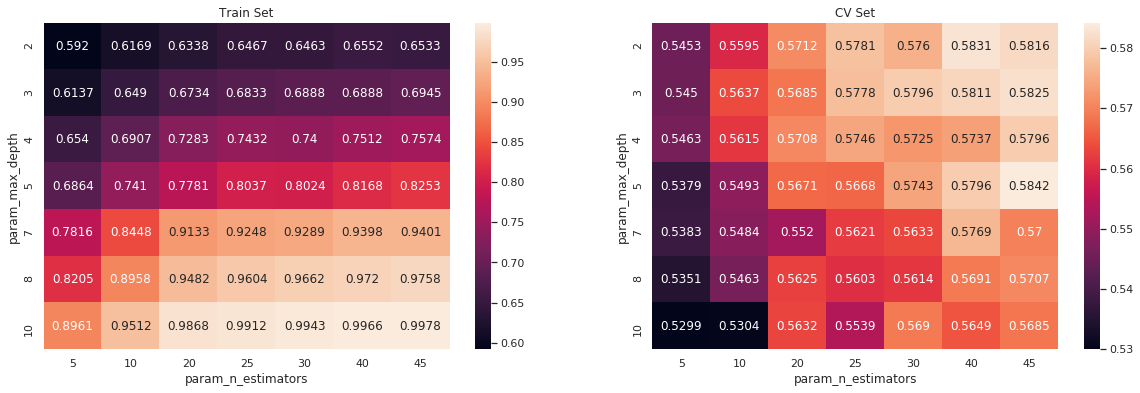

In [0]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
# from sklearn.multioutput import MultiOutputClassifier
# from sklearn.datasets import make_multilabel_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

Gt1 = RandomForestClassifier(class_weight='balanced',min_samples_split=5)
parameters = {'n_estimators': [5,10,20,25,30,40,45], 'max_depth':[2, 3, 4, 5, 7, 8, 10]}
clf1 = GridSearchCV(Gt1, parameters, cv=2, scoring='roc_auc',return_train_score=True)
se1 = clf1.fit(X_avg_w2v_train, y_train)

import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf1.cv_results_).groupby(['param_max_depth','param_n_estimators']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

# clf1.cv_results_.keys()

In [0]:
#Best Estimator and Best tune parameters
print(clf1.best_estimator_)
#Mean cross-validated score of the best_estimator
print(clf1.score(X_avg_w2v_train,y_train))
print(clf1.score(X_avg_w2v_test,y_test))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=45,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
0.7379111717531744
0.5858878787878787


In [0]:
best_tune_parameters=[{'n_estimators':[45], 'max_depth':[5] } ]

#### 2.5.2 Receiver Operating Characteristic-`(AVG_W2V)`

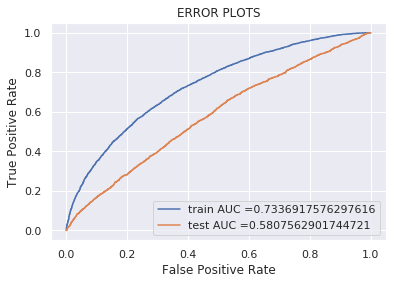

In [0]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc

clf11= RandomForestClassifier(class_weight = 'balanced',max_depth=5,n_estimators=45)
# clfV1=DecisionTreeClassifier (class_weight = 'balanced',max_depth=10,min_samples_split=500)
clf11.fit(X_avg_w2v_train, y_train)
# for visulation
# clfV1.fit(X_Tfidf_train, y_train)
#https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.decision_function
y_train_pred1 = clf11.predict_proba(X_avg_w2v_train) [:,1]
y_test_pred1 = clf11.predict_proba(X_avg_w2v_test) [:,1]
train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_train_pred1)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_test_pred1)
plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

#### 2.5.3 Confusion matrix-`AVG_W2V`

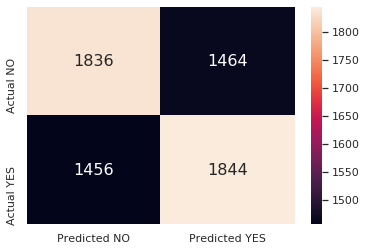

In [0]:
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
#function to get heatmap confusion matrix
def get_confusion_matrix(clf,X_te,y_test):
    y_pred = clf.predict(X_te)
    df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index =['Actual NO','Actual YES'],columns =['Predicted NO','Predicted YES'] )
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
# %%time
get_confusion_matrix(clf11,X_avg_w2v_test,y_test)


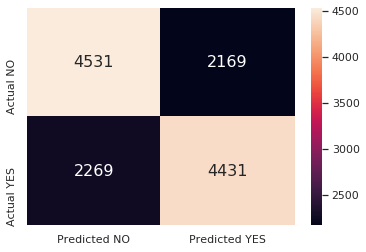

In [0]:
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
#function to get heatmap confusion matrix
def get_confusion_matrix(clf,X_te,y_test):
    y_pred = clf.predict(X_te)
    df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index =['Actual NO','Actual YES'],columns =['Predicted NO','Predicted YES'] )
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
# %%time
get_confusion_matrix(clf11,X_avg_w2v_train,y_train)


#### Selecting the Best features from the model

In [0]:
# from sklearn.feature_selection import SelectFromModel
# from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import SGDClassifier

# selector = SelectFromModel(estimator=SGDClassifier(max_depth=None,class_weight = 'balanced')).fit(X_avg_w2v_train, y_train)
# # selector.estimator_.coef_
# selector.threshold_
# selector.get_support()

In [0]:
x=X_avg_w2v_train
x1=X_avg_w2v_test
X_avg_w2v_train=None
X_avg_w2v_test=None
gc.collect()
# X_Tfidf_train.shape
# X_Tfidf_test.shape

3693

#### 2.5.4 Applying GBDT & GridSearchCV on Train data to obtain the best `C`

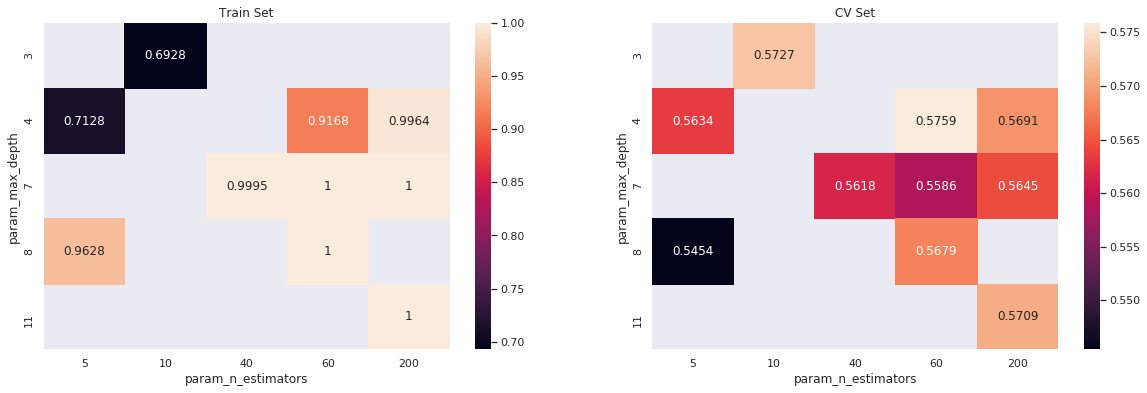

In [0]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

Gt1 = GradientBoostingClassifier(min_samples_split=15)
parameters = {'n_estimators': [5,10,20,40,60,80,100,150,200],'max_depth':[2,3,4,5,6,7,8,10,11] }
clf1 = RandomizedSearchCV(Gt1, parameters, cv=2, scoring='roc_auc',return_train_score=True)
se1 = clf1.fit(x, y_train)

import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf1.cv_results_).groupby(['param_max_depth','param_n_estimators']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

# clf1.cv_results_.keys()

In [0]:
#Best Estimator and Best tune parameters
print(clf1.best_estimator_)
#Mean cross-validated score of the best_estimator
print(clf1.score(x,y_train))
print(clf1.score(x1,y_test))

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=15,
                           min_weight_fraction_leaf=0.0, n_estimators=60,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
0.8182074961015816
0.5856307621671257


In [0]:
best_tune_parameters=[{'n_estimators':[60], 'max_depth':[4] } ]

#### 2.5.5 Receiver Operating Characteristic-`(AVG_W2V)`

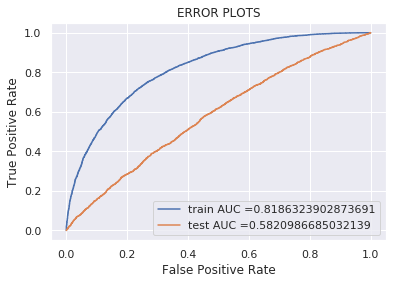

In [0]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc

clf11= GradientBoostingClassifier(max_depth=4,n_estimators=60)
# clfV1=DecisionTreeClassifier (class_weight = 'balanced',max_depth=10,min_samples_split=500)
clf11.fit(x, y_train)
# for visulation
# clfV1.fit(X_Tfidf_train, y_train)
#https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.decision_function
y_train_pred1 = clf11.predict_proba(x) [:,1]
y_test_pred1 = clf11.predict_proba(x1) [:,1]
train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_train_pred1)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_test_pred1)
plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

#### 2.5.6 Confusion matrix-`AVG_W2V`

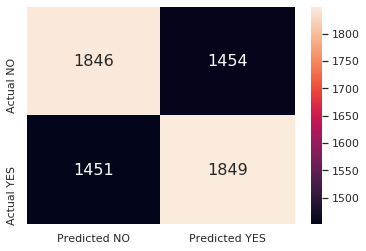

In [0]:
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
#function to get heatmap confusion matrix
def get_confusion_matrix(clf,X_te,y_test):
    y_pred = clf.predict(X_te)
    df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index =['Actual NO','Actual YES'],columns =['Predicted NO','Predicted YES'] )
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
# %%time
get_confusion_matrix(clf11,x1,y_test)


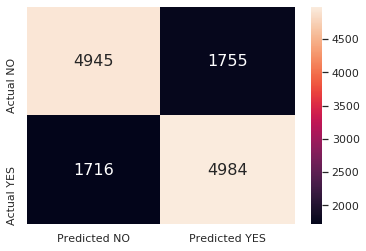

In [0]:
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
#function to get heatmap confusion matrix
def get_confusion_matrix(clf,X_te,y_test):
    y_pred = clf.predict(X_te)
    df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index =['Actual NO','Actual YES'],columns =['Predicted NO','Predicted YES'] )
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
# %%time
get_confusion_matrix(clf11,x,y_train)

In [0]:
#To make best use of the memory we are setting the variable names to 'None' and performing garbage collection.
# X_avg_w2v_test=None
# X_avg_w2v_train=None
# y_avg_w2v_train=None
x=None
x1=None
gc.collect()

####  2.10 Pretty table summary

In [2]:
#http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
    
x = PrettyTable()
x.field_names = ["Vectorizer","Model", "n_estimators","max_depth","Test-AUC"]


x.add_row(["BOW ","RF", '40','8', 68.16])
x.add_row(["BOW ","GBDT", '200','2', 70.16])
x.add_row(["TFIDF","RF", '60','7', 68.16])
x.add_row(["TFIDF","GBDT", '80','5', 69.67])
x.add_row(["TFIDF_weighted_W2V","RF", '45','3', 57.45])
x.add_row(["TFIDF_weighted_W2V","GBDT", '80','2', 58.80])
x.add_row(["AVG_W2V","RF", '45','5', 58.07])
x.add_row(["AVG_W2V","GBDT", '60','4', 58.20])

print(x) 

+--------------------+-------+--------------+-----------+----------+
|     Vectorizer     | Model | n_estimators | max_depth | Test-AUC |
+--------------------+-------+--------------+-----------+----------+
|        BOW         |   RF  |      40      |     8     |  68.16   |
|        BOW         |  GBDT |     200      |     2     |  70.16   |
|       TFIDF        |   RF  |      60      |     7     |  68.16   |
|       TFIDF        |  GBDT |      80      |     5     |  69.67   |
| TFIDF_weighted_W2V |   RF  |      45      |     3     |  57.45   |
| TFIDF_weighted_W2V |  GBDT |      80      |     2     |   58.8   |
|      AVG_W2V       |   RF  |      45      |     5     |  58.07   |
|      AVG_W2V       |  GBDT |      60      |     4     |   58.2   |
+--------------------+-------+--------------+-----------+----------+
